# Pymeos and Pyspark Partitioning Demo

First we perform the corresponding imports for the libraries to use.

In [1]:
from pymeos import *

from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.serializers import PickleSerializer
import pyspark.sql.functions as F

from pyspark.storagelevel import StorageLevel

from pysparkmeos.partitions.mobility_partitioner import MobilityPartitioner
from pysparkmeos.partitions.grid.grid_partitioner import GridPartition
from pysparkmeos.partitions.kdtree_partitioner import KDTreePartition
from pysparkmeos.partitions.kdtree_partitioner_spark import KDTreePartitionSpark
from pysparkmeos.partitions.adaptive_partitioner import AdaptiveBinsPartitioner
from pysparkmeos.partitions.adaptive_partitioner_spark import AdaptiveBinsPartitionerSpark
from pysparkmeos.partitions.approx_adaptive_partitioner import ApproximateAdaptiveBinsPartitioner
from pysparkmeos.partitions.bisecting_kmeans_partitioner import BisectingKMeansPartitioner
from pysparkmeos.UDT.MeosDatatype import *
from pysparkmeos.utils.udt_appender import udt_append
from pysparkmeos.utils.utils import *
from pysparkmeos.UDF.udf import *
from pysparkmeos.UDTF.base_partition_udtf import *

from typing import *
from time import time

import random, datetime

from datetime import timedelta
from functools import partial
from datetime import datetime, timezone
import contextily as cx
import distinctipy
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import shapely.geometry as shp
from pymeos.plotters import (
    TemporalPointSequenceSetPlotter,
    TemporalPointSequencePlotter,
)

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import os, sys
from shapely import wkb, box
import pandas as pd
from functools import reduce

testname = 'mini'

## Initialize Pymeos and setup Pyspark

In [2]:
# Initialize PyMEOS
pymeos_initialize("UTC")

os.environ['PYSPARK_DRIVER_PYTHON_OPTS']= "notebook"
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PYSPARK_PYTHON'] = sys.executable

# Initialize a Spark session
spark = SparkSession.builder \
    .appName("PySpark UDF Example with PyMEOS") \
    .master("local[3]") \
    .config("spark.default.parallelism", 3) \
    .config("spark.executor.memory", "3g") \
    .config("spark.executor.cores", 1) \
    .config("spark.driver.memory", "2g") \
    .config("spark.driver.maxResultSize", 0) \
    .config("spark.sql.allowMultipleTableArguments.enabled", True) \
    .getOrCreate()

#spark.sparkContext.setLogLevel("DEBUG")

# Append the UDT mapping to the PyMEOS classes
udt_append()
register_udfs_under_spark_sql(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/09 07:06:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/07/09 07:06:47 WARN SimpleFunctionRegistry: The function length replaced a previously registered function.


## Read the DataFrame and create the columns of Pymeos data objects

First, we are going to read a dataset from OpenSky, this dataset cointains the trajectory information of multiple flights within a timeframe.  

Using the latitude, longitude and timestamp we can create a PyMEOS TGeogPointInst, that in PySpark will be wrapped into a TGeogPointInstUDT object.

In [3]:
# Read data from a CSV file
#data_path = "../../small_mid_states_2022-06-27-00.csv"  # Update this with your CSV file path
#data_path = "../../sample.csv"
#data_path = "../../filtered_sample.csv"
data_path = "../../mini_states_2022-06-27-00.csv"
#data_path = "../../small_mid_states_2022-06-27-00.csv"

df = spark.read.csv(
    data_path, 
    header=True, 
    inferSchema=True, 
    mode='PERMISSIVE'
).select("icao24", "time", "lat", "lon")

# Clean nans, if not Points can't be created
df = df.dropna(subset=["lat", "lon", "time", "icao24"])

# Convert the 'time' column to the correct format
df = df \
    .withColumn("time", F.from_unixtime(F.col("time"), "yyyy-MM-dd' 'HH:mm:ss")) \
    .withColumn("lat", F.round("lat", 2)) \
    .withColumn("lon", F.round("lon", 2)) \
    .withColumn("Point", create_point_udf("lat", "lon", "time")) \
    .withColumn("x", get_point_x("Point")) \
    .withColumn("y", get_point_y("Point")) \
    .withColumn("t", get_point_timestamp("Point")) \
    .withColumn("id", F.monotonically_increasing_id())

df.show(3)

+------+-------------------+-----+------+--------------------+------+-----+-------------------+---+
|icao24|               time|  lat|   lon|               Point|     x|    y|                  t| id|
+------+-------------------+-----+------+--------------------+------+-----+-------------------+---+
|34718e|2022-06-27 00:00:00|40.87|  1.92|POINT(1.92 40.87)...|  1.92|40.87|2022-06-27 00:00:00|  0|
|ac6364|2022-06-27 00:00:00|33.14|-85.53|POINT(-85.53 33.1...|-85.53|33.14|2022-06-27 00:00:00|  1|
|406471|2022-06-27 00:00:00|51.91|  1.84|POINT(1.84 51.91)...|  1.84|51.91|2022-06-27 00:00:00|  2|
+------+-------------------+-----+------+--------------------+------+-----+-------------------+---+
only showing top 3 rows



Handling a dataset like this gives us granularity over the datapoints, but it would be better to group the trajectories together using another function, this will return the TGeogPointSeq objects representing each trajectory. Let's create a UDTF that takes the icao24, and Point, and creates a new table with icao24, and PointSeq.

In [25]:
print("Total row Point count: ", df.count())

df.groupBy("icao24").agg(F.count("Point").alias("cnt")).orderBy("cnt",ascending=False).show()

trajectories = df.groupBy("icao24").agg(
    F.collect_list(F.col("Point")).alias("PointSeq")
).select("icao24", "PointSeq").withColumn("PointSeq", tgeompointseq_from_instant_list("PointSeq"))


print("Total row PointSeq count after processing: ", trajectories.count())

trajectories.show(5)

Total row Point count:  941


+------+---+
|icao24|cnt|
+------+---+
|4d21ea|  2|
|a20f1a|  2|
|4ca9cc|  2|
|c04aa1|  2|
|4bb186|  1|
|a0f869|  1|
|3c5430|  1|
|a20a81|  1|
|a7b53a|  1|
|a5537f|  1|
|a08f76|  1|
|781009|  1|
|a1e5f8|  1|
|a1463a|  1|
|4074e2|  1|
|485a82|  1|
|a07105|  1|
|ac1fa5|  1|
|a472ab|  1|
|ab48cc|  1|
+------+---+
only showing top 20 rows

Total row PointSeq count after processing:  937


+------+--------------------+
|icao24|            PointSeq|
+------+--------------------+
|0101bd|[POINT(46.74 24.8...|
|010205|[POINT(13.54 42.7...|
|010207|[POINT(26.72 35.6...|
|02006f|[POINT(-1.74 37.8...|
|02a1a3|[POINT(6.18 37.32...|
+------+--------------------+
only showing top 5 rows



This has reduced the table from individual Points to much less sequences PointSeq!

Now we need to calculate the boundaries of the whole space of trajectories.

In [26]:
trajectories = trajectories.withColumn("STBox", point_to_stbox("PointSeq")).withColumn("seqId", F.monotonically_increasing_id())
trajectories.createOrReplaceTempView("trajectories")
trajectories.show()
trajectories.cache()
print(trajectories.count())

+------+--------------------+--------------------+-----------+
|icao24|            PointSeq|               STBox|      seqId|
+------+--------------------+--------------------+-----------+
|3c5430|[POINT(11.02 50.1...|STBOX XT(((11.02,...|          0|
|4bb186|[POINT(27.86 35.7...|STBOX XT(((27.86,...|          1|
|a0f869|[POINT(-95.49 29....|STBOX XT(((-95.49...|          2|
|a20a81|[POINT(-117.4 34....|STBOX XT(((-117.4...| 8589934592|
|a5537f|[POINT(-116.32 43...|STBOX XT(((-116.3...| 8589934593|
|a7b53a|[POINT(-76.07 43....|STBOX XT(((-76.07...| 8589934594|
|781009|[POINT(31.87 59.7...|STBOX XT(((31.87,...|17179869184|
|a08f76|[POINT(-74.93 39....|STBOX XT(((-74.93...|17179869185|
|a1463a|[POINT(-88.92 35....|STBOX XT(((-88.92...|17179869186|
|a1e5f8|[POINT(-84.92 39....|STBOX XT(((-84.92...|17179869187|
|4074e2|[POINT(-75.16 41....|STBOX XT(((-75.16...|25769803776|
|485a82|[POINT(17.25 45.3...|STBOX XT(((17.25,...|25769803777|
|a07105|[POINT(-108.66 38...|STBOX XT(((-108.6...|25769

24/07/09 07:39:48 WARN CacheManager: Asked to cache already cached data.


937


In [30]:
# We use the helper functions from utils to mapReduce the bounds of the whole dataset.
bounds = trajectories.rdd.mapPartitions(bounds_calculate_map).reduce(bounds_calculate_reduce)
bounds

STBoxWrap(STBOX XT(((-171.3,-46.42),(174.68,62.85)),[2022-06-27 00:00:00+00, 2022-06-27 00:00:10+00]))

## Generate the partitioning scheme and repartition data

In [7]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()

/tmp/ipykernel_59449/913829029.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


It is useful to materialize a table with the instants of the table that we will use as reference for the partititioning.

In [8]:
# Materialize Instants in dataframe
@F.udtf(returnType=StructType([
    StructField("seqId", IntegerType()),
    StructField("instant", TGeomPointInstUDT()),
    StructField("x", DoubleType()),
    StructField("y", DoubleType()),
    StructField("z", DoubleType()),
    StructField("t", TimestampType())
]))
class InstantsUDTF:
    def eval(self, row, utc="UTC"):
        pymeos_initialize(utc)
        instants = row.movingobject.instants()
        for instant in instants:
            z = None
            if instant.has_z():
                z = instant.z().start_value()
            yield row.trajectory_id, TGeomPointInstWrap(instant.__str__()), instant.x().start_value(), instant.y().start_value(), z, instant.start_timestamp()

spark.udtf.register("InstantsUDTF", InstantsUDTF)

@F.udtf(returnType=StructType([
    StructField("seqId", IntegerType()),
    StructField("instant", TGeomPointInstUDT()),
    StructField("x", DoubleType()),
    StructField("y", DoubleType()),
    StructField("z", DoubleType()),
    StructField("t", TimestampType()),
    StructField("rowNo", IntegerType()),
    StructField("ts", IntegerType())
]))
class IsAtUDTF:
    def eval(self, row, boundsstr, utc="UTC"):
        pymeos_initialize(utc)
        bounds = STBox(boundsstr)
        if row.instant.at(bounds):
            yield (row.seqId, row.instant, row.x, row.y, row.z, row.t, row.rowNo, row.ts)

spark.udtf.register("IsAtUDTF", IsAtUDTF)

instants = spark.sql(f"""
        SELECT * 
        FROM InstantsUDTF(
            TABLE(
                    SELECT 
                        seqId AS trajectory_id,
                        PointSeq AS movingobject
                    FROM trajectories
            )
        )

""").withColumn("rowNo", F.monotonically_increasing_id()).withColumn("ts", F.unix_timestamp("t"))

instants = instants.cache()
instants.createOrReplaceTempView("instants")
instants.show()

+-----+--------------------+-------+-----+----+-------------------+-----------+----------+
|seqId|             instant|      x|    y|   z|                  t|      rowNo|        ts|
+-----+--------------------+-------+-----+----+-------------------+-----------+----------+
|    0|POINT(11.02 50.15...|  11.02|50.15|NULL|2022-06-27 00:00:10|          0|1656288010|
|    1|POINT(27.86 35.75...|  27.86|35.75|NULL|2022-06-27 00:00:10|          1|1656288010|
|    2|POINT(-95.49 29.9...| -95.49|29.99|NULL|2022-06-27 00:00:10|          2|1656288010|
|    0|POINT(-117.4 34.4...| -117.4|34.41|NULL|2022-06-27 00:00:10| 8589934592|1656288010|
|    1|POINT(-116.32 43....|-116.32|43.67|NULL|2022-06-27 00:00:10| 8589934593|1656288010|
|    2|POINT(-76.07 43.0...| -76.07|43.04|NULL|2022-06-27 00:00:10| 8589934594|1656288010|
|    0|POINT(31.87 59.74...|  31.87|59.74|NULL|2022-06-27 00:00:10|17179869184|1656288010|
|    1|POINT(-74.93 39.0...| -74.93|39.04|NULL|2022-06-27 00:00:10|17179869185|1656288010|

In [9]:
pointsample = [traj.PointSeq for traj in trajectories.select('PointSeq').collect()] #  Take real sample if datasize is too big

In [31]:
start = time()
# Regular Grid
gp = GridPartition(cells_per_side=3, bounds=bounds)
grid = gp.as_spark_table()
grid.cache()
print("Regular Grid Partitioning PySpark Table")
grid.show()
grid.createOrReplaceTempView("RegularGrid")
end = time()
print(f"{end-start} seconds to process and create Regular Grid.")

24/07/09 07:44:06 WARN CacheManager: Asked to cache already cached data.


Regular Grid Partitioning PySpark Table
+------+--------------------+
|tileid|                tile|
+------+--------------------+
|     0|STBOX XT(((-171.3...|
|     1|STBOX XT(((-171.3...|
|     2|STBOX XT(((-171.3...|
|     3|STBOX XT(((-171.3...|
|     4|STBOX XT(((-171.3...|
|     5|STBOX XT(((-171.3...|
|     6|STBOX XT(((-171.3...|
|     7|STBOX XT(((-171.3...|
|     8|STBOX XT(((-171.3...|
|     9|STBOX XT(((-55.97...|
|    10|STBOX XT(((-55.97...|
|    11|STBOX XT(((-55.97...|
|    12|STBOX XT(((-55.97...|
|    13|STBOX XT(((-55.97...|
|    14|STBOX XT(((-55.97...|
|    15|STBOX XT(((-55.97...|
|    16|STBOX XT(((-55.97...|
|    17|STBOX XT(((-55.97...|
|    18|STBOX XT(((59.353...|
|    19|STBOX XT(((59.353...|
+------+--------------------+
only showing top 20 rows

1.0653457641601562 seconds to process and create Regular Grid.


In [11]:
"""
start = time()
# KDTree
gpkd = KDTreePartition(moving_objects=pointsample, dimensions=['x', 'y', 't'], bounds=bounds, max_depth=4)
gridkd = gpkd.as_spark_table()
gridkd.cache()
print("KD Tree Partitioning PySpark Table")
gridkd.show()
gridkd.createOrReplaceTempView("KDTree")
end = time()
print(f"{end-start} seconds to process and create KD Tree Grid.")
"""

'\nstart = time()\n# KDTree\ngpkd = KDTreePartition(moving_objects=pointsample, dimensions=[\'x\', \'y\', \'t\'], bounds=bounds, max_depth=4)\ngridkd = gpkd.as_spark_table()\ngridkd.cache()\nprint("KD Tree Partitioning PySpark Table")\ngridkd.show()\ngridkd.createOrReplaceTempView("KDTree")\nend = time()\nprint(f"{end-start} seconds to process and create KD Tree Grid.")\n'

In [12]:
"""
start = time()
# Adaptive
agp = AdaptiveBinsPartitioner(bounds=bounds, movingobjects=pointsample, num_tiles=3, dimensions=['x', 'y', 't'], utc="UTC")
gridagp = agp.as_spark_table()
gridagp.cache()
print("Adaptive Bins Partitioning PySpark Table")
gridagp.show()
gridagp.createOrReplaceTempView("AdaptiveBins")
end = time()
print(f"{end-start} seconds to process and create Adaptive Bins Grid.")
"""

'\nstart = time()\n# Adaptive\nagp = AdaptiveBinsPartitioner(bounds=bounds, movingobjects=pointsample, num_tiles=3, dimensions=[\'x\', \'y\', \'t\'], utc="UTC")\ngridagp = agp.as_spark_table()\ngridagp.cache()\nprint("Adaptive Bins Partitioning PySpark Table")\ngridagp.show()\ngridagp.createOrReplaceTempView("AdaptiveBins")\nend = time()\nprint(f"{end-start} seconds to process and create Adaptive Bins Grid.")\n'

In [13]:
"""
start = time()
# Adaptive with Spark background
sagp = AdaptiveBinsPartitionerSpark(spark, bounds, 'trajectories', 'PointSeq', 3, dimensions=['x', 'y', 't'], utc="UTC")
gridsagp = sagp.as_spark_table()
gridsagp.cache()
print("Adaptive Bins Partitioning Spark Background Table")
gridsagp.show()
gridsagp.createOrReplaceTempView("AdaptiveBinsWithSpark")
end = time()
print(f"{end-start} seconds to process and create Adaptive Bins Grid with Spark.")
"""

'\nstart = time()\n# Adaptive with Spark background\nsagp = AdaptiveBinsPartitionerSpark(spark, bounds, \'trajectories\', \'PointSeq\', 3, dimensions=[\'x\', \'y\', \'t\'], utc="UTC")\ngridsagp = sagp.as_spark_table()\ngridsagp.cache()\nprint("Adaptive Bins Partitioning Spark Background Table")\ngridsagp.show()\ngridsagp.createOrReplaceTempView("AdaptiveBinsWithSpark")\nend = time()\nprint(f"{end-start} seconds to process and create Adaptive Bins Grid with Spark.")\n'

In [14]:
start = time()
# Approximate Adaptive
agp2 = ApproximateAdaptiveBinsPartitioner(df=trajectories, colname='PointSeq', bounds=bounds, num_tiles=3, dimensions=['x', 'y'], utc="UTC")
gridagp2 = agp2.as_spark_table()
gridagp2.cache()
print("Approximate Adaptive Bins Partitioning PySpark Table")
gridagp2.show()
gridagp2.createOrReplaceTempView("ApproximateAdaptiveBins")
end = time()
print(f"{end-start} seconds to process and create Approximate Adaptive Bins Grid.")

Approximate Adaptive Bins Partitioning PySpark Table
+------+--------------------+
|tileid|                tile|
+------+--------------------+
|     0|STBOX XT(((-171.3...|
|     1|STBOX XT(((-79.45...|
|     2|STBOX XT(((-49.3,...|
|     3|STBOX XT(((-171.3...|
|     4|STBOX XT(((-79.45...|
|     5|STBOX XT(((-49.3,...|
|     6|STBOX XT(((-171.3...|
|     7|STBOX XT(((-79.45...|
|     8|STBOX XT(((-49.3,...|
+------+--------------------+

55.309327840805054 seconds to process and create Approximate Adaptive Bins Grid.


In [15]:
instants.show()

+-----+--------------------+-------+-----+----+-------------------+-----------+----------+
|seqId|             instant|      x|    y|   z|                  t|      rowNo|        ts|
+-----+--------------------+-------+-----+----+-------------------+-----------+----------+
|    0|POINT(11.02 50.15...|  11.02|50.15|NULL|2022-06-27 00:00:10|          0|1656288010|
|    1|POINT(27.86 35.75...|  27.86|35.75|NULL|2022-06-27 00:00:10|          1|1656288010|
|    2|POINT(-95.49 29.9...| -95.49|29.99|NULL|2022-06-27 00:00:10|          2|1656288010|
|    0|POINT(-117.4 34.4...| -117.4|34.41|NULL|2022-06-27 00:00:10| 8589934592|1656288010|
|    1|POINT(-116.32 43....|-116.32|43.67|NULL|2022-06-27 00:00:10| 8589934593|1656288010|
|    2|POINT(-76.07 43.0...| -76.07|43.04|NULL|2022-06-27 00:00:10| 8589934594|1656288010|
|    0|POINT(31.87 59.74...|  31.87|59.74|NULL|2022-06-27 00:00:10|17179869184|1656288010|
|    1|POINT(-74.93 39.0...| -74.93|39.04|NULL|2022-06-27 00:00:10|17179869185|1656288010|

In [16]:
start = time()
# KDTree with Spark
instantsmini = instants.limit(50)
instantsmini.createOrReplaceTempView('instantsMini')
instants = spark.sql(f"""
        SELECT * 
        FROM InstantsUDTF(
            TABLE(
                    SELECT 
                        seqId AS trajectory_id,
                        PointSeq AS movingobject
                    FROM trajectories
            )
        )

""").withColumn("rowNo", F.monotonically_increasing_id()).withColumn("ts", F.unix_timestamp("t"))
instants.createOrReplaceTempView('instants')
instants = instants.cache()

sgpkd = KDTreePartitionSpark(spark, instants, 'instants', 'instant', 'seqId', bounds, ['x', 'y', 't'], 2, "UTC")
sgridkd = sgpkd.as_spark_table()
sgridkd.cache()
print("KD Tree Partitioning PySpark Table")
sgridkd.show()
sgridkd.createOrReplaceTempView("KDTreeWithSpark")
end = time()
print(f"{end-start} seconds to process and create KD Tree with Spark Grid.")

24/07/09 07:10:00 WARN CacheManager: Asked to cache already cached data.


KD Tree Partitioning PySpark Table
+------+--------------------+
|tileid|                tile|
+------+--------------------+
|     0|STBOX XT(((-171.3...|
|     1|STBOX XT(((-171.3...|
|     2|STBOX XT(((-85.42...|
|     3|STBOX XT(((-85.42...|
+------+--------------------+

150.19736242294312 seconds to process and create KD Tree with Spark Grid.


In [17]:
start = time()
# Bisecting KMeans
bkp = BisectingKMeansPartitioner(bounds, instants, 'instant', 3)
for tile in bkp.grid:
    print(tile)
gridbkp = bkp.as_spark_table()
gridbkp.cache()
print("Bisecting K Means Partitioning PySpark Table")
gridbkp.show(truncate=False)
gridbkp.createOrReplaceTempView("BisectingKMeans")
end = time()
print(f"{end-start} seconds to process and create Bisecting K Means Grid.")

24/07/09 07:13:09 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


STBOX XT(((-171.3,-0.28),(8.39,62.85)),[2022-06-27 00:00:00+00, 2022-06-27 00:00:10+00])
STBOX XT(((-11.73,34.66),(102.84,61.68)),[2022-06-27 00:00:10+00, 2022-06-27 00:00:10+00])
STBOX XT(((-47.25,-46.42),(174.68,40.55)),[2022-06-27 00:00:10+00, 2022-06-27 00:00:10+00])
Bisecting K Means Partitioning PySpark Table


+------+-------------------------------------------------------------------------------------------+
|tileid|tile                                                                                       |
+------+-------------------------------------------------------------------------------------------+
|0     |STBOX XT(((-171.3,-0.28),(8.39,62.85)),[2022-06-27 00:00:00+00, 2022-06-27 00:00:10+00])   |
|1     |STBOX XT(((-11.73,34.66),(102.84,61.68)),[2022-06-27 00:00:10+00, 2022-06-27 00:00:10+00]) |
|2     |STBOX XT(((-47.25,-46.42),(174.68,40.55)),[2022-06-27 00:00:10+00, 2022-06-27 00:00:10+00])|
+------+-------------------------------------------------------------------------------------------+

211.9702262878418 seconds to process and create Bisecting K Means Grid.


/tmp/ipykernel_59449/869017697.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


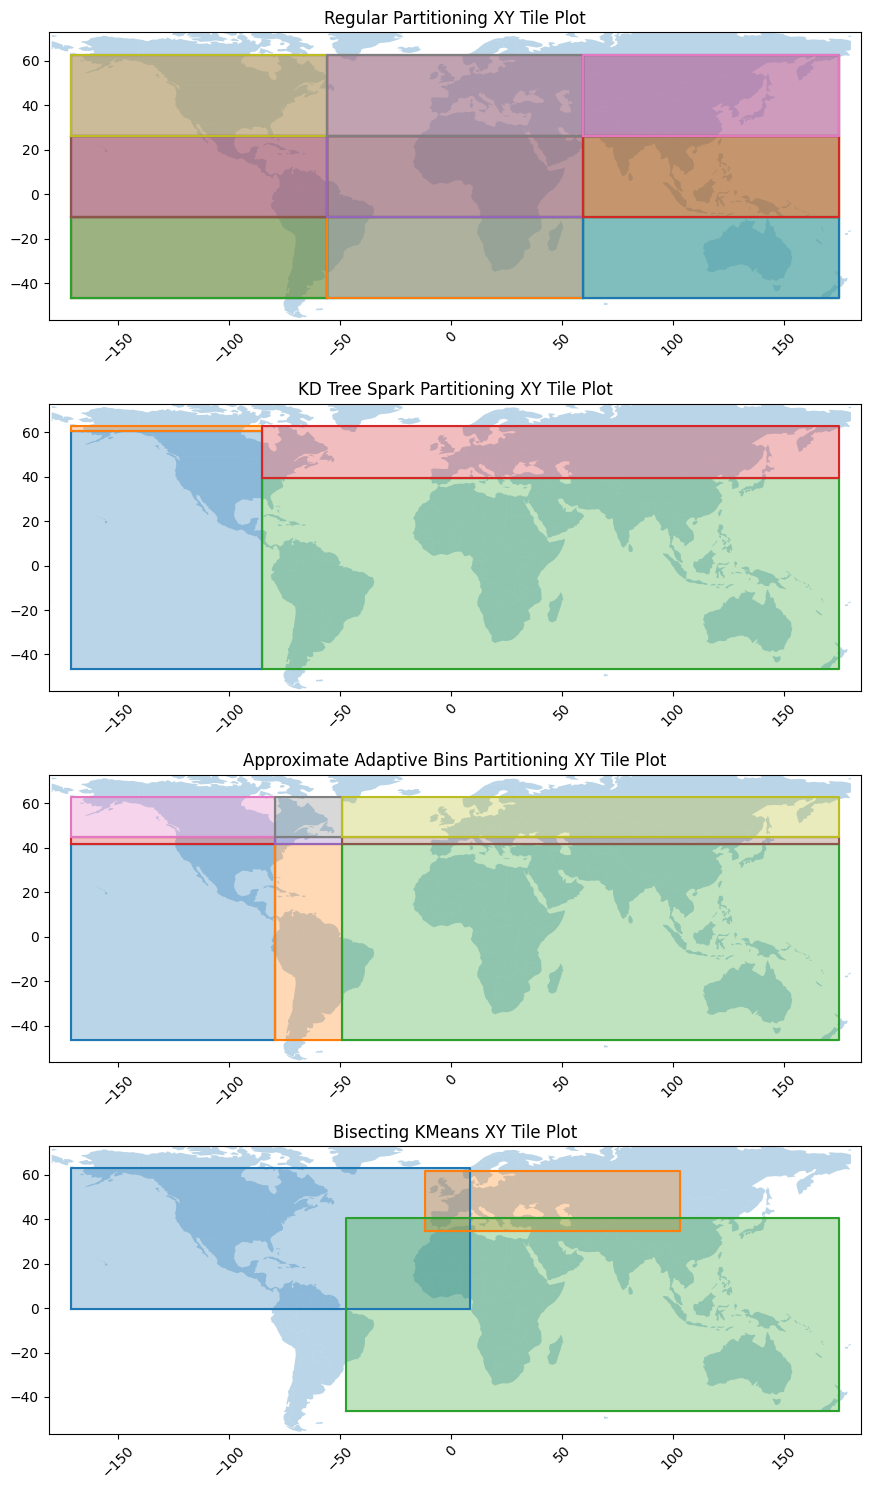

In [32]:
# Now we calculate the grid and partition accordingly
fig, ax = plt.subplots(4, 1, figsize=(15, 15))
fig.subplots_adjust(hspace=0.5)  # Increase the value to add more space

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#world = world[world['continent'] == 'North America']

minx = bounds.expand(10.0).xmin()
maxx = bounds.expand(10.0).xmax()
miny = bounds.expand(10.0).ymin()
maxy = bounds.expand(10.0).ymax()


for a in ax:
    world.plot(ax=a, alpha=0.3)

gp.plot(axes=ax[0])
ax[0].title.set_text("Regular Partitioning XY Tile Plot")

#gpkd.plot(axes=ax[1])
#ax[1].title.set_text("KD Tree Partitioning XY Tile Plot")

sgpkd.plot(axes=ax[1])
ax[1].title.set_text("KD Tree Spark Partitioning XY Tile Plot")

#agp.plot(axes=ax[3])
#ax[3].title.set_text("Adaptive Bins Partitioning XY Tile Plot")

agp2.plot(axes=ax[2])
ax[2].title.set_text("Approximate Adaptive Bins Partitioning XY Tile Plot")

#sagp.plot(axes=ax[5])
#ax[5].title.set_text("Adaptive Bins with Spark XY Tile Plot")

bkp.plot(axes=ax[3])
ax[3].title.set_text("Bisecting KMeans XY Tile Plot")

for i, _ in enumerate(ax):
    ax[i].set_xlim(minx, maxx)
    ax[i].set_ylim(miny, maxy)

# Adjust layout
fig.tight_layout()

# Save each subplot as an SVG file with labels
for i, axis in enumerate(ax):
    extent = axis.get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f'subplot_{i+1}_{testname}.svg', bbox_inches=extent)  # Adjust expanded() parameters as needed

plt.show()

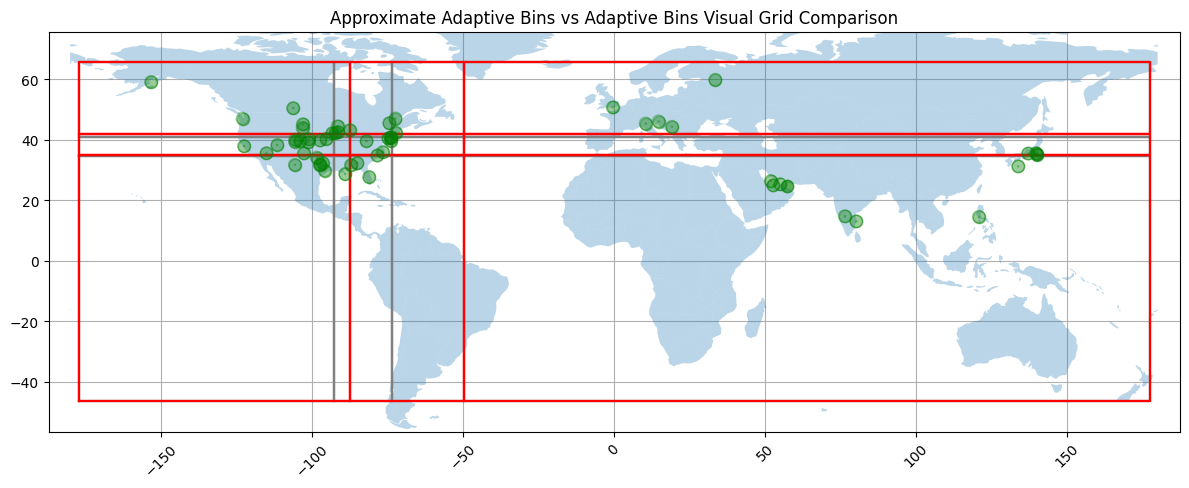

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
world.plot(ax=ax, alpha=0.3)
agp.plot(axes=ax, draw_filling=False, color='grey')
agp2.plot(axes=ax, draw_filling=False, color='red')

for idx, row in enumerate(trajectories.sample(0.01, seed=0.3).toLocalIterator()):
    TemporalPointSequencePlotter.plot_xy(
        row.PointSeq, axes=ax, show_markers=True, show_grid=True, color=('green',0.4)
    )

ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Adjust layout
fig.tight_layout()

# Save each subplot as an SVG file with labels
extent = ax.get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())
fig.savefig(f'compare_bins_{testname}.svg', bbox_inches=extent)  # Adjust expanded() parameters as needed

ax.title.set_text("Approximate Adaptive Bins vs Adaptive Bins Visual Grid Comparison")
plt.show()

In [33]:
%time

# Call the base udtf partitioner as it is useful in this usecase.
@F.udtf(returnType=partition_schema)  # Schema imported from base_partition_udtf file.
class PartitionUDTF(BasePartitionUDTF):
    def __init__(self):
        self.response_extra_cols = []
        self.check_function = None
        self.return_full_traj = False
        
    def eval(self, row: Row):
        for val in super().eval_wrap(row):
            yield val
            
spark.udtf.register("PartitionUDTF", PartitionUDTF)

def map_partition_rdd(index, rows):
    for row in rows:
        yield (row['tileid'], row)

def partition_trajectories(spark, gridname, gridclass):
    trajectoriesPartMap = spark.sql(f"""
        SELECT * 
        FROM PartitionUDTF(
            TABLE(
                    SELECT 
                        seqId AS trajectory_id, 
                        PointSeq AS movingobject, 
                        (SELECT collect_list(tile) FROM {gridname}) AS tiles, 
                        (SELECT collect_list(tileid) FROM {gridname}) AS tileids
                    FROM trajectories
            )
        )
    """)
    num_partitions = gridclass.num_partitions()
    trajectoriesPartMapRdd = None
    trajectoriesPartMap = trajectoriesPartMap.withColumnRenamed("movingobject", "trajectory").withColumnRenamed("movingobjectid", "trajectoryId").withColumnRenamed("tileid", "partitionKey")
    if gridname == 'RegularGrid':
        trajectoriesPartMap.show()
    #trajectoriesPartMapRdd = trajectoriesPartMap.rdd.mapPartitionsWithIndex(map_partition_rdd).partitionBy(num_partitions)
    #trajectoriesPartMap = trajectoriesPartMapRdd.toDF(["partitionKey", "trajectorydata"]).withColumn("trajectory", F.col("trajectorydata.movingobject")).withColumn("trajectoryId", F.col("trajectorydata.movingobjectid")).drop("trajectorydata")
    #print(f"{gridname} Partitioned Trajectories.")
    #trajectoriesPartMap.show()
    return trajectoriesPartMap, trajectoriesPartMapRdd, gridclass, gridname


partMaps = [
    partition_trajectories(spark, gridname, gridclass) 
    #for gridname, gridclass in zip(
    #    ['RegularGrid', 'KDTree', 'AdaptiveBins', 'ApproximateAdaptiveBins', 'KDTreeWithSpark', 'AdaptiveBinsWithSpark', 'BisectingKMeans'], 
    #    [gp, gpkd, agp, agp2, sgpkd, sagp, bkp]
    #)
    for gridname, gridclass in zip(
        ['RegularGrid', 'ApproximateAdaptiveBins', 'KDTreeWithSpark', 'BisectingKMeans'], 
        [gp, agp2, sgpkd, bkp]
    )
]

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 13.6 µs


24/07/09 07:44:33 WARN SimpleTableFunctionRegistry: The function partitionudtf replaced a previously registered function.


+-------------+------------+--------------------+
| trajectoryId|partitionKey|          trajectory|
+-------------+------------+--------------------+
| 274877906945|          15|{[POINT(8.01 48.9...|
| 274877906945|          16|{[POINT(8.013 48....|
| 274877906945|          17|{[POINT(8.016 48....|
| 309237645313|          15|{[POINT(1.84 51.9...|
| 532575944706|           6|{[POINT(-77.71 42...|
| 532575944706|           7|{[POINT(-77.707 4...|
| 532575944706|           8|{[POINT(-77.704 4...|
| 609885356032|          15|{[POINT(8.39 47.5...|
| 609885356032|          16|{[POINT(8.381 47....|
| 609885356032|          17|{[POINT(8.372 47....|
| 953482739712|          15|{[POINT(1.92 40.8...|
| 987842478084|           6|{[POINT(-83.46 33...|
|1030792151042|           6|{[POINT(-85.53 33...|
|1443109011460|           6|{[POINT(-79.31 42...|
|1443109011460|           7|{[POINT(-79.31 42...|
|1443109011460|           8|{[POINT(-79.31 42...|
+-------------+------------+--------------------+


## Show the partition distribution

RegularGrid partition distribution.


+------------+-----+
|partitionKey|count|
+------------+-----+
|           6|    4|
|           7|    2|
|           8|    2|
|          15|    4|
|          16|    2|
|          17|    2|
+------------+-----+



+-----------+----------------+
|average_ppp|      stddev_ppp|
+-----------+----------------+
|      342.0|335.423612764516|
+-----------+----------------+

Mean:  2.6666666666666665
Std:  1.0327955589886446
ApproximateAdaptiveBins partition distribution.


+------------+-----+
|partitionKey|count|
+------------+-----+
|           0|  392|
|           1|  102|
|           2|  141|
|           3|   55|
|           4|   41|
|           5|   16|
|           6|   61|
|           7|   16|
|           8|  114|
+------------+-----+



+-----------+----------------+
|average_ppp|      stddev_ppp|
+-----------+----------------+
|      342.0|335.423612764516|
+-----------+----------------+

Mean:  104.22222222222223
Std:  116.25594369512659
KDTreeWithSpark partition distribution.


+------------+-----+
|partitionKey|count|
+------------+-----+
|           0|  392|
|           1|    8|
|           2|  251|
|           3|  290|
+------------+-----+



+-----------+----------------+
|average_ppp|      stddev_ppp|
+-----------+----------------+
|      342.0|335.423612764516|
+-----------+----------------+

Mean:  235.25
Std:  162.74596769198308
BisectingKMeans partition distribution.


+------------+-----+
|partitionKey|count|
+------------+-----+
|           0|  729|
|           1|  162|
|           2|  135|
+------------+-----+



+-----------+----------------+
|average_ppp|      stddev_ppp|
+-----------+----------------+
|      342.0|335.423612764516|
+-----------+----------------+

Mean:  342.0
Std:  335.423612764516


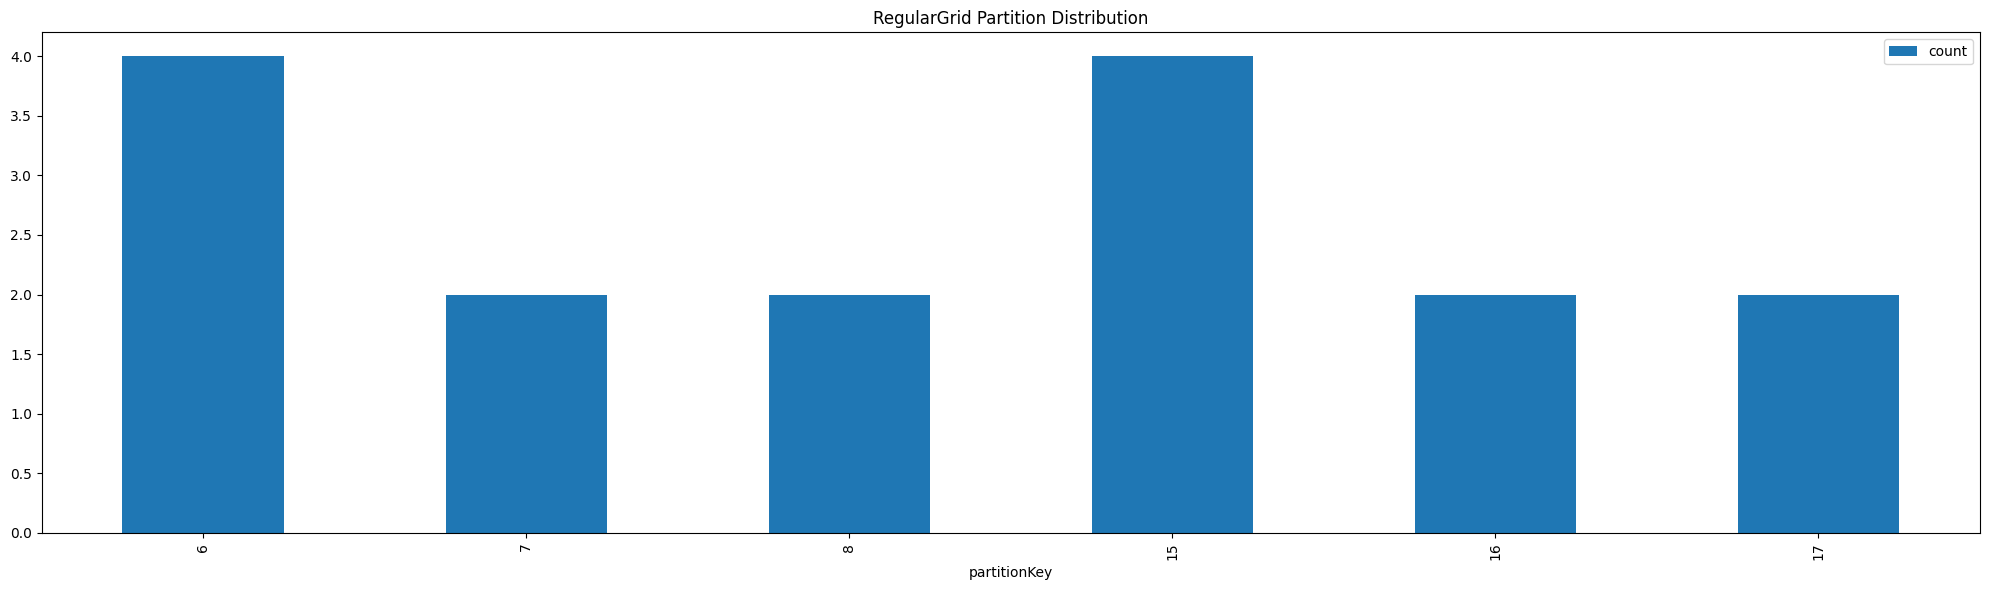

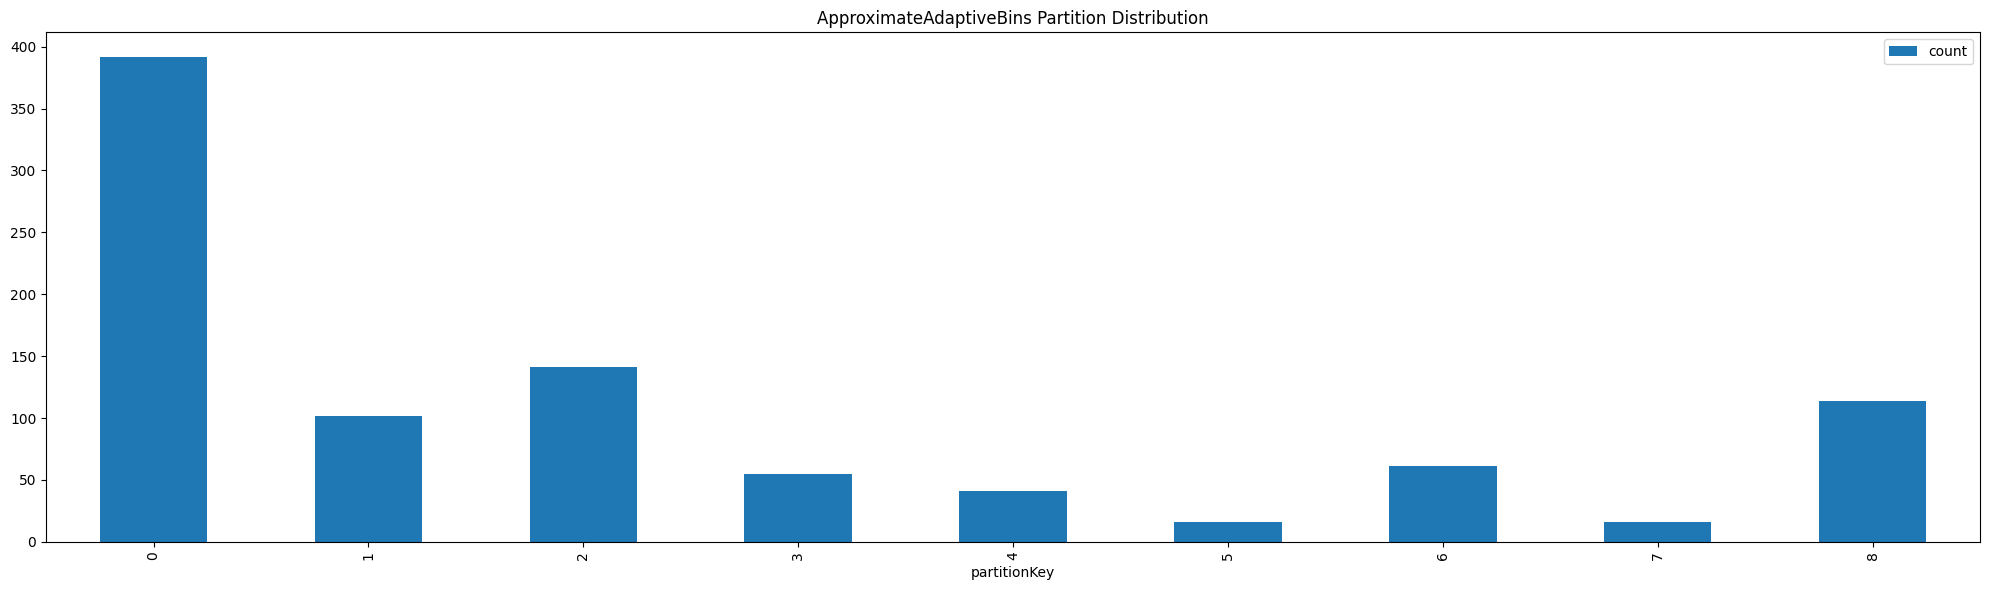

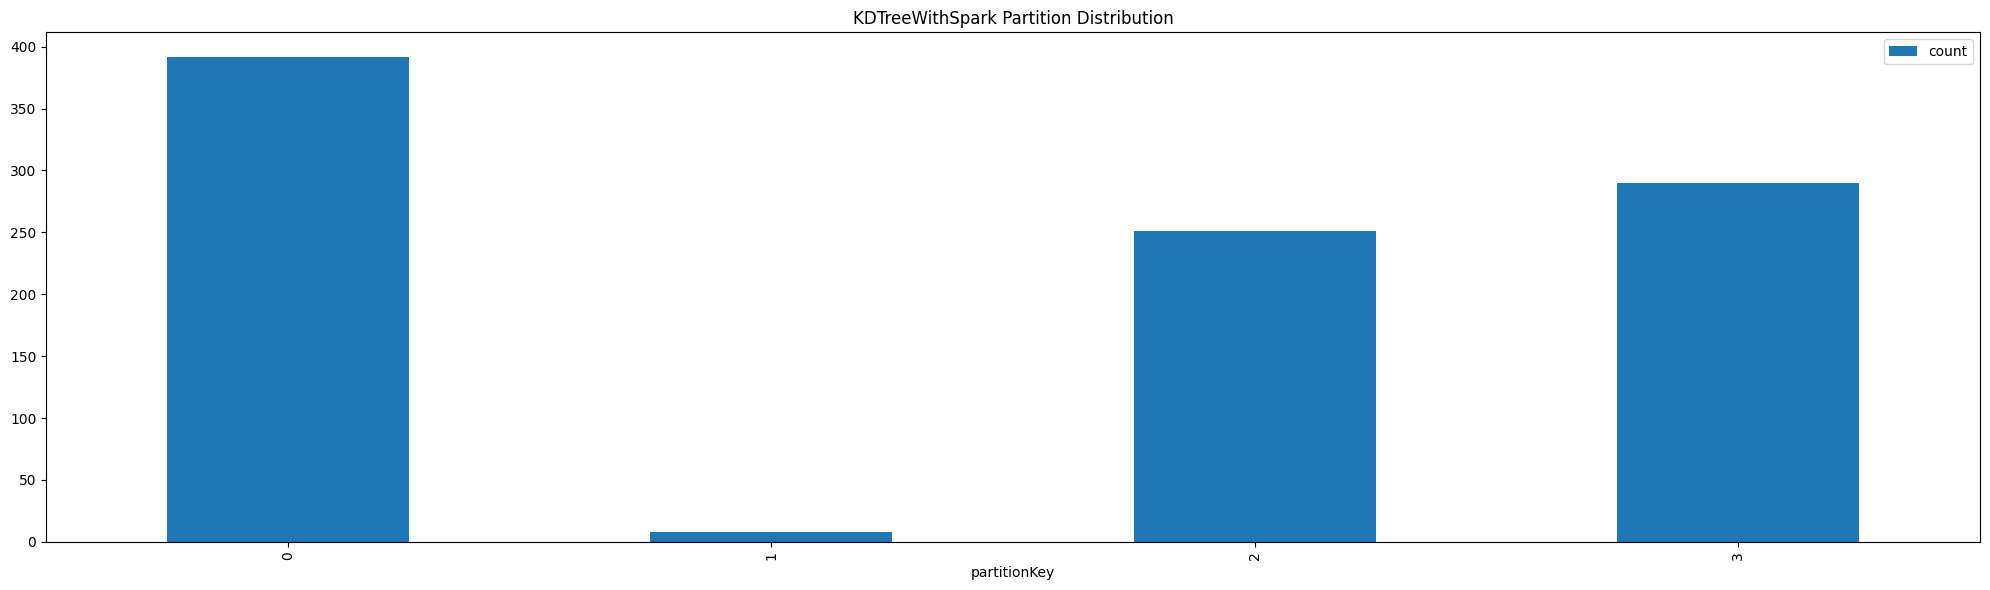

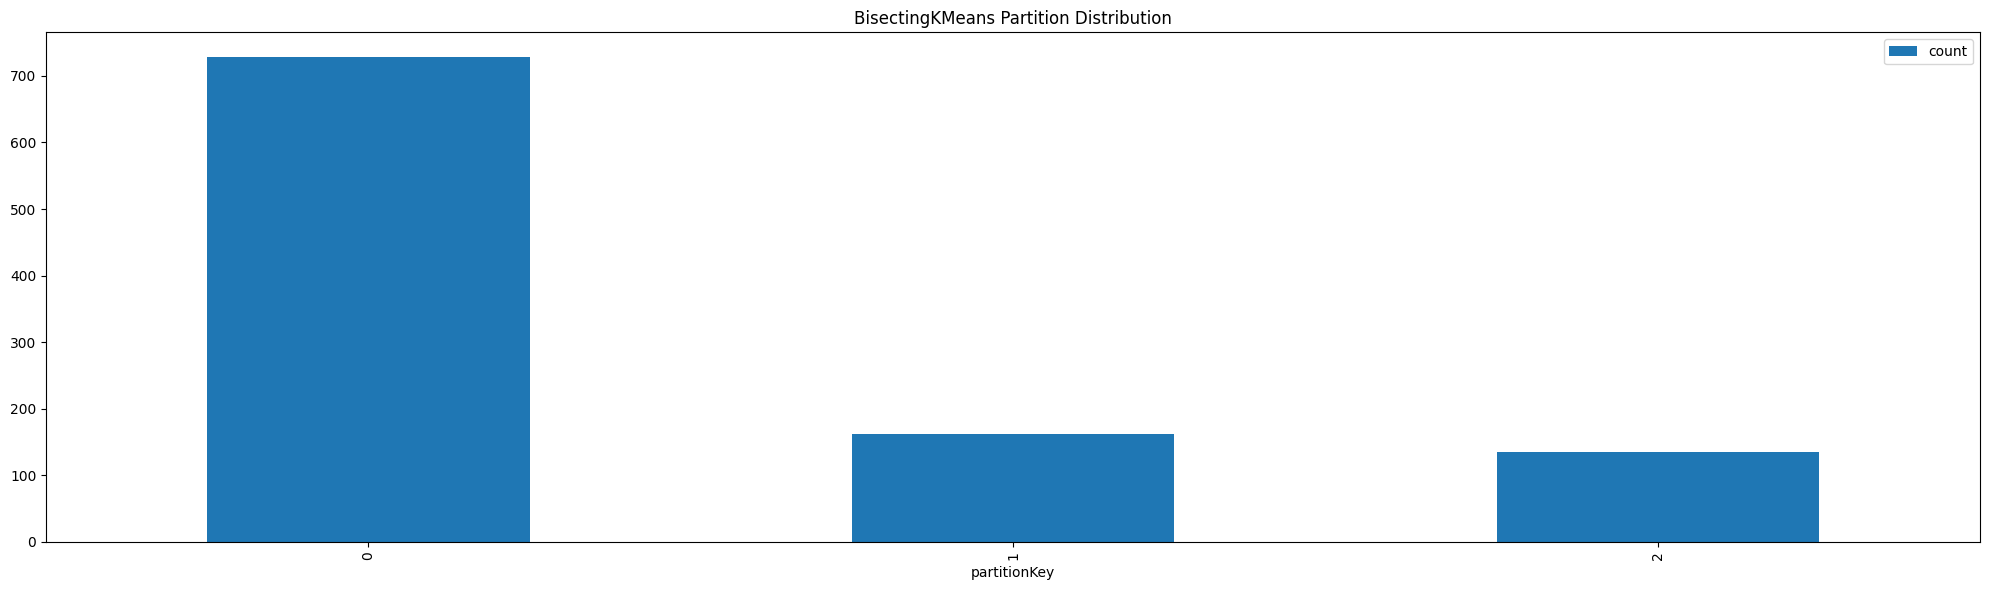

CPU times: user 15.2 s, sys: 5.28 s, total: 20.5 s
Wall time: 4min


In [34]:
%%time

for trajectoriesPartMap, _, _, gridname in partMaps:
    print(f"{gridname} partition distribution.")
    
    trajectoriesPartMapCounts = trajectoriesPartMap.groupBy("partitionKey").count().orderBy('partitionKey')
    trajectoriesPartMapCounts.show(1000)

    # Convert the Spark DataFrame to a Pandas DataFrame
    pdf = trajectoriesPartMapCounts.toPandas()

    # Plot with modified figure size
    fig, ax = plt.subplots(figsize=(20, 6))  # Adjust the width and height as needed
    pdf.plot.bar(x='partitionKey', y='count', ax=ax, title=f'{gridname} Partition Distribution')
    
    # Adjust layout and save fig
    fig.tight_layout()
    extent = ax.get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f'distribution_{gridname}_{testname}.svg', bbox_inches=extent)  # Adjust expanded() parameters as needed

    #stats = trajectoriesPartMapCounts.agg(
    #    F.mean(F.col("count")).alias("average_ppp"),
    #    F.stddev(F.col("count")).alias("stddev_ppp")
    #)

    stats.show()
    
    print("Mean: ", pdf['count'].mean())
    print("Std: ", pdf['count'].std())

    #trajectoriesPartRdd = trajectoriesPartMap.rdd
    #print(trajectoriesPartRdd.getNumPartitions())
    
    # Function to count rows per partition
    def count_in_partition(idx, iterator):
        cnt = 0
        for _ in iterator:
            cnt += 1
        return [(idx, cnt)]
    
    # Using mapPartitionsWithIndex to count rows per partition
    #partition_counts = trajectoriesPartRdd.mapPartitionsWithIndex(count_in_partition).collect()
        
    # Print the results
    #for partition_id, cnt in partition_counts:
    #    print(f"Partition {partition_id} has {cnt} rows")
    
    #trajectoriesPartMap.show()

plt.show()

## Plot the Projection of the grid and the distribution of data

In [19]:
# Get a sample of the data to plot (for big datasets > 1000 trajectories)
seqIdRows = spark.sql("SELECT seqId AS seqId FROM trajectories TABLESAMPLE(50 ROWS)").collect()
#seqIdRows = spark.sql("SELECT seqId AS seqId FROM trajectories").collect()
seqIds = {row.seqId for row in seqIdRows}
seqIds = trajectories.sample(0.03, seed=3)
#print(len(seqIds))

/tmp/ipykernel_19399/664772937.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


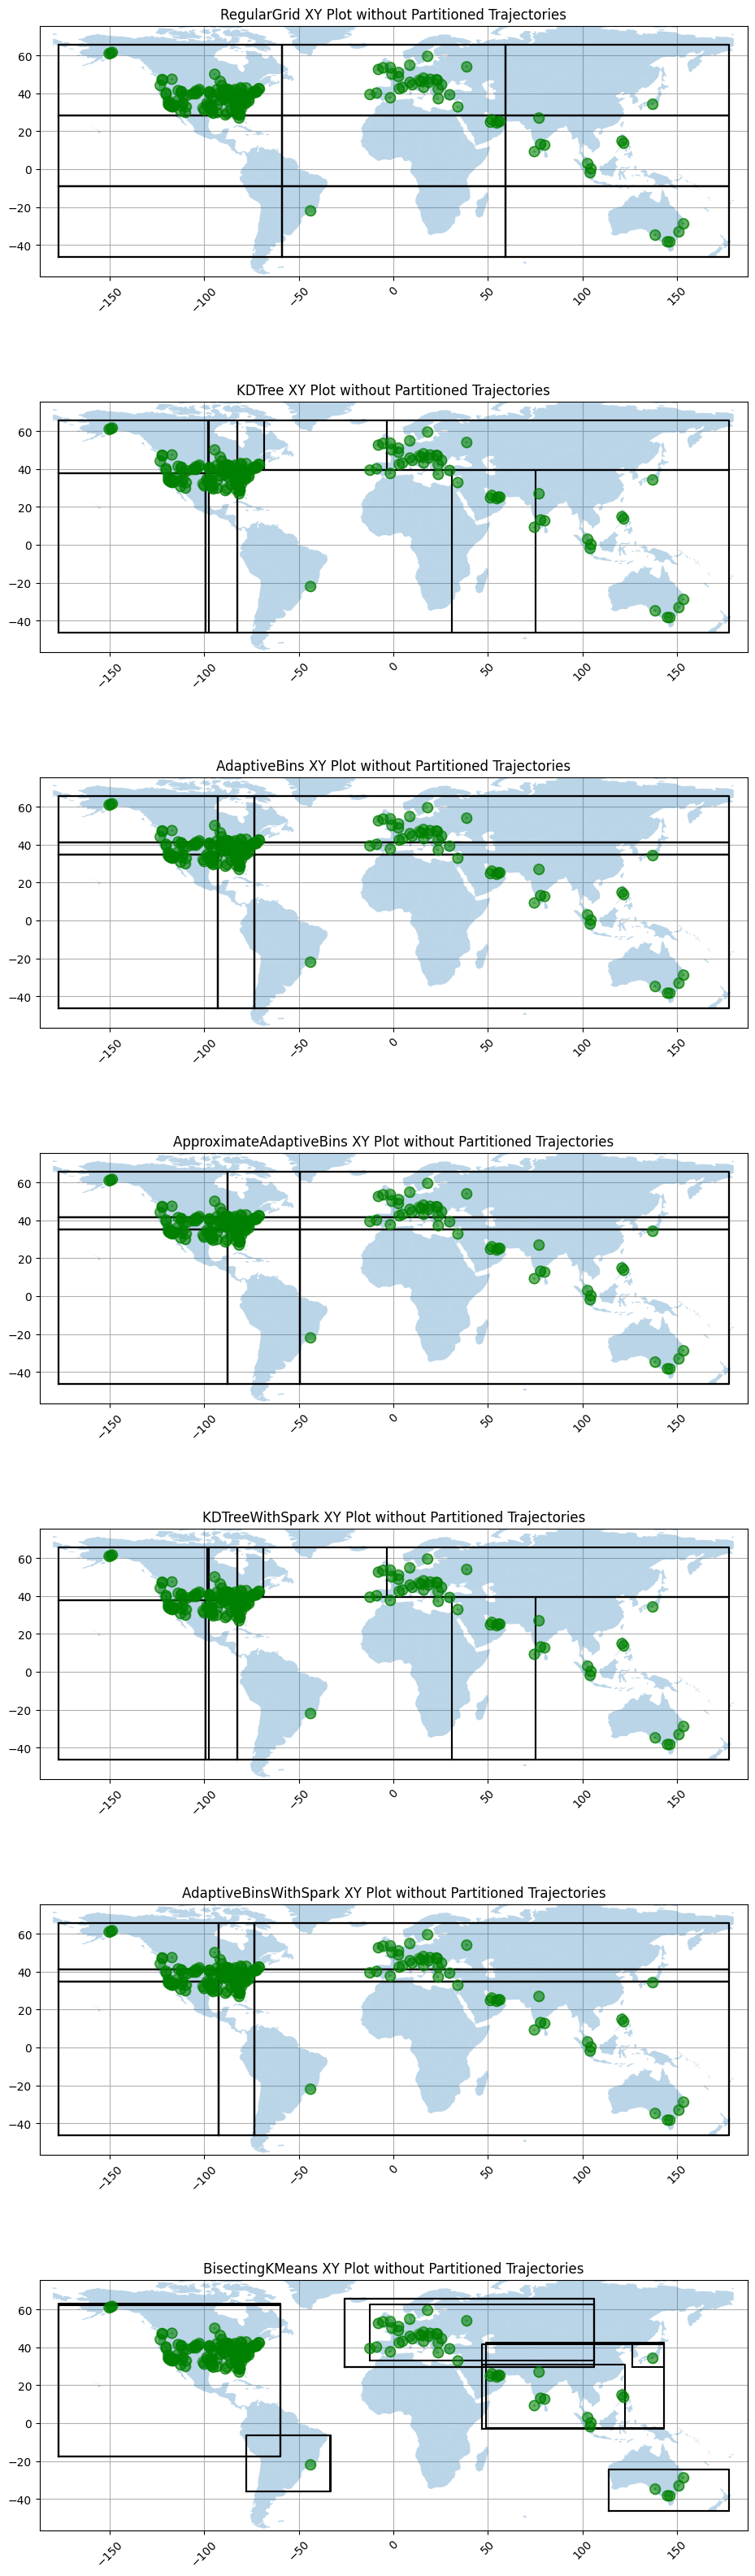

In [28]:
fig, ax = plt.subplots(len(partMaps), 1, figsize=(40, 40))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#world = world[world['continent'] == 'North America']

minx = bounds.expand(10.0).xmin()
maxx = bounds.expand(10.0).xmax()
miny = bounds.expand(10.0).ymin()
maxy = bounds.expand(10.0).ymax()

#for i in range(0, len(partMaps)*2, 2):
#    trajectoriesMap, partMapRdd, gridclass, gridname = partMaps[i]
#    j = i+1

fig.subplots_adjust(hspace=0.5)  # Increase the value to add more space

for i, (trajectoriesMap, partMapRdd, gridclass, gridname) in enumerate(partMaps):
    world.plot(ax=ax[i], alpha=0.3)
    #world.plot(ax=ax[j], alpha=0.3)

    gridclass.plot(axes=ax[i], color='black', draw_filling=False)
    #gridclass.plot(axes=ax[j], color='black', draw_filling=False)

    colors = plt.cm.Accent(np.linspace(0, 1, len(gridclass.tilesstr)))
    # Adding an alpha value when creating the color map
    alpha_value = 1.0
    color_map = {i: colors[i][:3].tolist() + [alpha_value] for i, _ in enumerate(gridclass.tilesstr)}
    trajectory_colors = ['red', 'green', 'blue', 'yellow', 'orange', 'pink', 'lightgreen', 'darkblue']

    trajectory_idx = {}
    """
    for idx, row in enumerate(trajectoriesPartMap.where(trajectoriesPartMap.trajectoryId.isin(seqIds)).toLocalIterator()):
        if row.trajectoryId in trajectory_idx:
            c = trajectory_idx[row.trajectoryId]
        else:
            c = idx
            trajectory_idx[row.trajectoryId] = idx
        traj = row.trajectory
        TemporalPointSequenceSetPlotter.plot_xy(
            traj, axes=ax[j], show_markers=True, show_grid=True 
        )
    """
    for idx, row in enumerate(seqIds.toLocalIterator()):
        if row.icao24 in trajectory_idx:
            c = trajectory_idx[row.icao24]
        else:
            c = idx
            trajectory_idx[row.icao24] = idx
        TemporalPointSequencePlotter.plot_xy(
            row.PointSeq, axes=ax[i], show_markers=True, show_grid=True, color=('green', 0.6) 
        )
    ax[i].set_xlim(minx, maxx)
    ax[i].set_ylim(miny, maxy)
    #ax[j].set_xlim(minx, maxx)
    #ax[j].set_ylim(miny, maxy)
    ax[i].title.set_text(f"{gridname} XY Plot without Partitioned Trajectories")
    #ax[j].title.set_text(f"{gridname} XY Plot with Partitioned Trajectories")

# Save each subplot as an SVG file with labels
for i, axis in enumerate(ax):
    extent = axis.get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f'dots_subplot_{i+1}_{testname}.svg', bbox_inches=extent)  # Adjust expanded() parameters as needed

plt.show()